In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from parcels import FieldSet, ParticleSet, Variable, Field
from parcels import JITParticle,AdvectionRK4, AdvectionRK4_3D, ErrorCode, plotTrajectoriesFile
import numpy as np
from datetime import timedelta
import netCDF4
import os
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

In [23]:
def AdvectionAnalytical(particle, fieldset, time, dt):
    """Advection of particles using 'analytical advection' integration
    Based on Ariane/TRACMASS algorithm, as detailed in e.g. Doos et al (https://doi.org/10.5194/gmd-10-1733-2017)
    Only works in scipy mode for now on a 2d stationary flow (so no time evolution)
    Requires an extra fieldset constant: fieldset.grid_type='C' or
    fieldset.grid_type='A', for C and A grids respectively.
    """
    if fieldset.grid_type == 'C':
        # get the lat/lon arrays (C-grid)
        lats_u, lons_u = fieldset.U.grid.lat, fieldset.U.grid.lon
        lats_v, lons_v = fieldset.V.grid.lat, fieldset.V.grid.lon
        lats_p, lons_p = fieldset.P.grid.lat, fieldset.P.grid.lon

        # request corner indices of grid cell (P-grid!) and rx, ry (indices are to the bottom left of particle)
        rx, ry, _, xi, yi, _ = fieldset.P.search_indices_rectilinear(particle.lon, particle.lat, particle.depth, 0, 0)

        # calculate grid resolution
        dx = lons_p[xi + 1] - lons_p[xi]
        dy = lats_p[yi + 1] - lats_p[yi]

        # request velocity at particle position
        up, vp = fieldset.UV[time, particle.lon, particle.lat, particle.depth]

        # shift the grid cell corner indices 1 to the west and/or south if necessary
        # also move rx, ry to '1' if they move west/south and are on a grid face
        if up >= 0 or rx > 0:
            a1, a2 = 0, 1
        else:
            a1, a2 = -1, 0
            rx = 1.

        if vp >= 0 or ry > 0:
            b1, b2 = 0, 1
        else:
            b1, b2 = -1, 0
            ry = 1.

        # set the r_1 target value based on the particle flow direction
        ry_target = 1. if vp >= 0. else 0.
        rx_target = 1. if up >= 0. else 0.

        # get velocities at the surrounding grid boxes
        u_w = fieldset.U[time, lons_u[xi+a1], lats_u[yi+b1], particle.depth]
        u_e = fieldset.U[time, lons_u[xi+a2], lats_u[yi+b1], particle.depth]
        v_s = fieldset.V[time, lons_v[xi+a1], lats_v[yi+b1], particle.depth]
        v_n = fieldset.V[time, lons_v[xi+a1], lats_v[yi+b2], particle.depth]
    elif fieldset.grid_type == 'A':
        # request corner indices and xsi, eta (indices are to the bottom left of particle)
        rx, ry, _, xi, yi, _ = fieldset.U.search_indices_rectilinear(particle.lon, particle.lat, particle.depth, 0, 0)

        # request velocity at particle position
        up, vp = fieldset.UV[time, particle.lon, particle.lat, particle.depth]

        # get the lat/lon arrays (A-grid!)
        lats = fieldset.P.grid.lat
        lons = fieldset.P.grid.lon

        # set the grid box indices based on the velocity direction or position
        # also move rx, ry to '1' if they move west/south and are on a grid face
        if up >= 0 or rx > 0:
            a1, a2 = 0, 1
        else:
            a1, a2 = -1, 0
            rx = 1.

        if vp >= 0 or ry > 0:
            b1, b2 = 0, 1
        else:
            b1, b2 = -1, 0
            ry = 1.

        ry_target = 1. if vp >= 0. else 0.
        rx_target = 1. if up >= 0. else 0.

        # get velocities at the surrounding grid boxes
        u1, v1 = fieldset.UV[time, lons[xi + a1], lats[yi + b1], particle.depth]
        u2, v2 = fieldset.UV[time, lons[xi + a2], lats[yi + b1], particle.depth]
        u3, v3 = fieldset.UV[time, lons[xi + a1], lats[yi + b2], particle.depth]
        u4, v4 = fieldset.UV[time, lons[xi + a2], lats[yi + b2], particle.depth]

        # define new variables for velocity for C-grid
        u_w = (u1 + u3) / 2.
        u_e = (u2 + u4) / 2.
        v_s = (v1 + v2) / 2.
        v_n = (v3 + v4) / 2.

        # get the dx/dy
        dx = lons[xi + 1] - lons[xi]
        dy = lats[yi + 1] - lats[yi]
    else:
        raise NotImplementedError('Only A and C grids implemented')

    # calculate the zonal and meridional grid face fluxes
    F_w = u_w * dy
    F_e = u_e * dy
    F_s = v_s * dx
    F_n = v_n * dx

    # calculate betas
    B_x = F_w - F_e
    B_y = F_s - F_n

    # delta
    delta_x = - F_w - B_x * 0.  # where r_(i-1) = 0 by definition
    delta_y = - F_s - B_y * 0.  # where r_(j-1) = 0 by definition

    # calculate F(r0) and F(r1) for both directions (unless beta == 0)
    if B_x != 0.:
        Fu_r1 = rx_target + delta_x / B_x
        Fu_r0 = rx + delta_x / B_x
    else:
        Fu_r0, Fu_r1 = None, None
    if B_y != 0.:
        Fv_r1 = ry_target + delta_y / B_y
        Fv_r0 = ry + delta_y / B_y
    else:
        Fv_r0, Fv_r1 = None, None

    # set tolerance of when something is considered 0
    tol = 1e-8

    # set betas accordingly
    B_x = 0 if abs(B_x) < tol else B_x
    B_y = 0 if abs(B_y) < tol else B_y

    # calculate delta s for x direction
    if B_x == 0 and delta_x == 0:
        ds_x = float('inf')
    elif B_x == 0:
        ds_x = (rx_target - rx) / delta_x
    elif Fu_r1 * Fu_r0 < 0:
        ds_x = float('inf')
    else:
        ds_x = - 1 / B_x * math.log(Fu_r1 / Fu_r0)

    # calculate delta s for y direction
    if B_y == 0 and delta_y == 0:
        ds_y = float('inf')
    elif B_y == 0:
        ds_y = (ry_target - ry) / delta_y
    elif Fv_r1 * Fv_r0 < 0:
        ds_y = float('inf')
    else:
        ds_y = - 1 / B_y * math.log(Fv_r1 / Fv_r0)

    # take the minimum travel time
    s_min = min(ds_x, ds_y)

    # calculate end position in time s_min
    if ds_y == float('inf'):
        rs_x = rx_target
        rs_y = ry
    elif ds_x == float('inf'):
        rs_x = rx
        rs_y = ry_target
    else:
        if B_x == 0:
            rs_x = -delta_x * s_min + rx
        else:
            rs_x = (rx + delta_x/B_x) * math.exp(-B_x*s_min) - delta_x / B_x

        if B_y == 0:
            rs_y = -delta_y * s_min + ry
        else:
            rs_y = (ry + delta_y/B_y) * math.exp(-B_y*s_min) - delta_y / B_y

    # calculate the change in position in cartesian coordinates
    dlon = (rs_x - rx) * dx
    dlat = (rs_y - ry) * dy

    # set new position (round to 8th decimal, due to floating point precision issues)
    particle.lat = round(particle.lat + dlat, 8)
    particle.lon = round(particle.lon + dlon, 8)

    # feedback the passed time to main loop (does not work as intended)
    s_min_real = s_min * (dx * dy)
    particle.dt = s_min_real


In [4]:
# globfiles = ["/Users/hart-davis/Desktop/rome_avg_200010_0122.nc"]


In [24]:
globfiles = "/Users/hart-davis/Desktop/Scripts/global-analysis-forecast-phy-001-024_1526032258244.nc"
filenames = {'U': globfiles,
             'V': globfiles}

variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

grid_type = 'A'
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, 
                                allow_time_extrapolation=True,transpose=False)
fieldset.grid_type = grid_type

In [25]:
class Particle(JITParticle):  # Define a new particle class that contains three extra variables
    wet_dry = Variable('wet_dry',dtype=np.float32)
    u = Variable('u', dtype=np.float32)
    v = Variable('v', dtype=np.float32)

def SampleUV(particle, fieldset, time, dt):
    particle.u = fieldset.U[time, particle.lon, particle.lat, particle.depth]
    particle.v = fieldset.V[time, particle.lon, particle.lat, particle.depth]
    
nc = xr.open_dataset("/Users/hart-davis/Desktop/rome_avg_200010_0122.nc")

In [26]:
lonW = 20 #western part of deployment box
lonE = 20 #eastern part of deployment box
latS = -35#southern part of deployment box
latN = -35#northern part of deployment box
particles = 10 #number of particles one wants to deploy

#depths = fieldset.U.depth[-1]*np.ones((particles))

lons, lats= np.meshgrid(np.linspace(lonW,lonE,np.sqrt(particles)), \
                            np.linspace(latS,latN,np.sqrt(particles))) 
pset = ParticleSet.from_list(fieldset=fieldset, pclass=Particle, lon=lons, lat=lats)#,depth=depths)


/Users/hart-davis/miniconda2/envs/parcels/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [27]:
try:
    os.remove("testing_a.nc")
except: pass
output_file = pset.ParticleFile(name="testing_a",outputdt=timedelta(hours=6))

kernels = pset.Kernel(AdvectionAnalytical) #+ SampleUV  + BrownianMotion2D

def DeleteParticle(particle, fieldset, time, dt): 
    particle.delete()
    
pset.execute(kernels, runtime=timedelta(days=12),dt=timedelta(hours=6),output_file=output_file,
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

Exception AttributeError: "'Kernel' object has no attribute '_lib'" in <bound method Kernel.__del__ of <parcels.kernel.Kernel object at 0x33caeae50>> ignored


AttributeError: 'FieldNode' object has no attribute 'grid'

In [38]:
def peninsula_fieldset(xdim, ydim, mesh, grid_type='A'):
    """Construct a fieldset encapsulating the flow field around an
    idealised peninsula.

    :param xdim: Horizontal dimension of the generated fieldset
    :param xdim: Vertical dimension of the generated fieldset
    :param mesh: String indicating the type of mesh coordinates and
               units used during velocity interpolation:

               1. spherical (default): Lat and lon in degree, with a
                  correction for zonal velocity U near the poles.
               2. flat: No conversion, lat/lon are assumed to be in m.
    :param grid_type: Option whether grid is either Arakawa A (default) or C

    The original test description can be found in Fig. 2.2.3 in:
    North, E. W., Gallego, A., Petitgas, P. (Eds). 2009. Manual of
    recommended practices for modelling physical - biological
    interactions during fish early life.
    ICES Cooperative Research Report No. 295. 111 pp.
    http://archimer.ifremer.fr/doc/00157/26792/24888.pdf

    """
    # Set Parcels FieldSet variables

    # Generate the original test setup for pressure field in km
    dx = 100. / xdim
    dy = 50. / ydim
    La = np.linspace(dx, 100.-dx, xdim, dtype=np.float32)
    Wa = np.linspace(dy, 50.-dy, ydim, dtype=np.float32)

    u0 = 1
    x0 = 50.
    R = 0.32 * 50.

    # Create the fields
    x, y = np.meshgrid(La, Wa, sparse=True, indexing='xy')
    P = u0*R**2*y/((x-x0)**2+y**2)-u0*y

    if grid_type is 'A':
        U = u0-u0*R**2*((x-x0)**2-y**2)/(((x-x0)**2+y**2)**2)
        V = -2*u0*R**2*((x-x0)*y)/(((x-x0)**2+y**2)**2)
    elif grid_type is 'C':
        U = np.zeros(P.shape)
        V = np.zeros(P.shape)
        V[:, 1:-1] = (P[:, 2:] - P[:, :-2]) / (2 * dx)
        V[:, 0] = (P[:, 1] - P[:, 0]) / dx
        V[:, -1] = (P[:, -1] - P[:, -2]) / dx
        U[1:-1, :] = -(P[2:, :] - P[:-2, :]) / (2 * dy)
        U[0, :] = -(P[1, :] - P[0, :]) / dy
        U[-1, :] = -(P[-1, :] - P[-2, :]) / dy
    else:
        raise RuntimeError('Grid_type %s is not a valid option' % grid_type)

    # Set land points to NaN
    landpoints = P >= 0.
    U[landpoints] = np.nan
    V[landpoints] = np.nan
    print U
    if mesh == 'spherical':
        # Convert from km to lat/lon
        lon = La / 1.852 / 60.
        lat = Wa / 1.852 / 60.
    elif mesh == 'flat':
        # Convert from km to m
        lon = La * 1000.
        lat = Wa * 1000.
    else:
        raise RuntimeError('Mesh %s is not a valid option' % mesh)

    data = {'U': U, 'V': V, 'P': P}
    dimensions = {'lon': lon, 'lat': lat}
    return FieldSet.from_data(data, dimensions, mesh=mesh)

In [39]:
test_fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, 
                                allow_time_extrapolation=True,transpose=False)

In [40]:
from datetime import timedelta as delta
def pensinsula_example(fieldset, npart, mode='jit', degree=1,
                       verbose=False, output=True, method=AdvectionRK4):
    """Example configuration of particle flow around an idealised Peninsula

    :arg filename: Basename of the input fieldset
    :arg npart: Number of particles to intialise"""

    # First, we define a custom Particle class to which we add a
    # custom variable, the initial stream function value p.
    # We determine the particle base class according to mode.
    class MyParticle(JITParticle):
        # JIT compilation requires a-priori knowledge of the particle
        # data structure, so we define additional variables here.
        p = Variable('p', dtype=np.float32, initial=0.)
        p_start = Variable('p_start', dtype=np.float32, initial=fieldset.P)

        def __repr__(self):
            """Custom print function which overrides the built-in"""
            return "P(%.4f, %.4f)[p=%.5f, p_start=%f]" % (self.lon, self.lat,
                                                          self.p, self.p_start)

    # Initialise particles
    if fieldset.U.grid.mesh == 'flat':
        x = 3000  # 3 km offset from boundary
    else:
        x = 3. * (1. / 1.852 / 60)  # 3 km offset from boundary
    y = (fieldset.U.lat[0] + x, fieldset.U.lat[-1] - x)  # latitude range, including offsets
    pset = ParticleSet.from_line(fieldset, size=npart, pclass=MyParticle,
                                 start=(x, y[0]), finish=(x, y[1]), time=0)

    if verbose:
        print("Initial particle positions:\n%s" % pset)

    # Advect the particles for 24h
    time = delta(hours=24)
    dt = delta(minutes=5)
    k_adv = pset.Kernel(method)
    k_p = pset.Kernel(UpdateP)
    out = pset.ParticleFile(name="MyParticle", outputdt=delta(hours=1)) if output else None
    print("Peninsula: Advecting %d particles for %s" % (npart, str(time)))
    pset.execute(k_adv + k_p, runtime=time, dt=dt, output_file=out)

    if verbose:
        print("Final particle positions:\n%s" % pset)

    return pset

import os

def test_peninsula_fieldset_AnalyticalAdvection():
    """Execute peninsula test using Analytical Advection on C grid"""
    try: os.remove("MyParticle.nc")
    except: pass
    grid_type = "C"
    fieldset = peninsula_fieldset(100, 50, 'flat')
    fieldset.grid_type = grid_type
    fieldset.U.grid_type = grid_type
    fieldset.V.grid_type = grid_type
#     fieldset.U.interp_method = 'cgrid_linear'
#     fieldset.V.interp_method = 'cgrid_linear'
    pset = pensinsula_example(fieldset, npart=10, mode='scipy', method=AdvectionAnalytical)
    # Test advection accuracy by comparing streamline values
    err_adv = np.array([abs(p.p_start - p.p) for p in pset])
    assert(err_adv <= 1.e-2).all()

In [41]:
test_peninsula_fieldset_AnalyticalAdvection()

[[ 0.89351088  0.88908011  0.88436699 ...,  0.88436699  0.88908011
   0.89351088]
 [ 0.89389843  0.8895005   0.88482392 ...,  0.88482392  0.8895005
   0.89389843]
 [ 0.89453733  0.89019352  0.88557684 ...,  0.88557684  0.89019352
   0.89453733]
 ..., 
 [ 0.99773723  0.99884444  1.00002539 ...,  1.00002539  0.99884444
   0.99773723]
 [ 0.99890184  1.00001192  1.00119281 ...,  1.00119281  1.00001192
   0.99890184]
 [ 1.          1.00111008  1.00228798 ...,  1.00228798  1.00111008  1.        ]]


Exception AttributeError: "'Kernel' object has no attribute '_lib'" in <bound method Kernel.__del__ of <parcels.kernel.Kernel object at 0x33caea890>> ignored


AttributeError: 'FieldNode' object has no attribute 'grid'

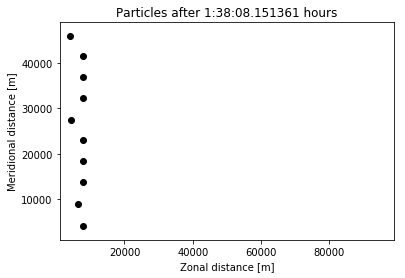

In [78]:
pset.show()